In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree


start = datetime.datetime(2018, 11, 1)
end = datetime.datetime(2019, 10, 31)

df = web.DataReader("NFLX", 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-11-01,318.450012,296.670013,304.589996,317.380005,15121500,317.380005
2018-11-02,321.880005,308.329987,318.000000,309.100006,13404600,309.100006
2018-11-05,317.529999,303.739990,311.100006,315.440002,10283000,315.440002
2018-11-06,320.220001,305.299988,314.760010,310.839996,9710400,310.839996
2018-11-07,328.559998,311.000000,312.899994,327.500000,13328300,327.500000


In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

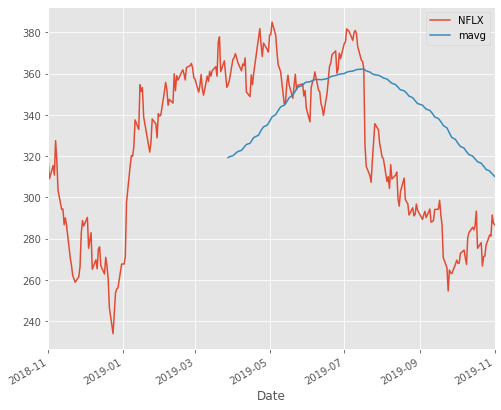

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='NFLX')
mavg.plot(label='mavg')
plt.legend()

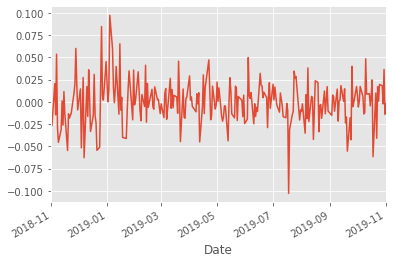

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [6]:
dfcomp = web.DataReader(['NFLX', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [7]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

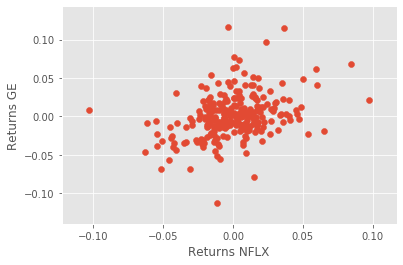

In [8]:
plt.scatter(retscomp.NFLX, retscomp.GE)
plt.xlabel('Returns NFLX')
plt.ylabel('Returns GE')

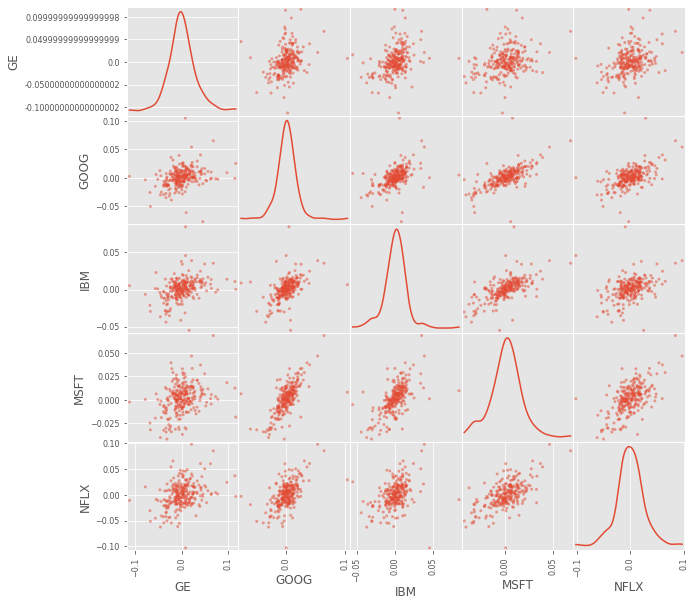

In [9]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

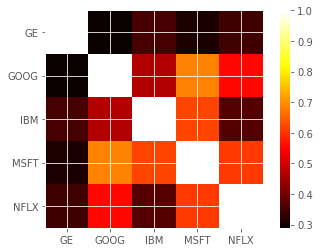

In [10]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

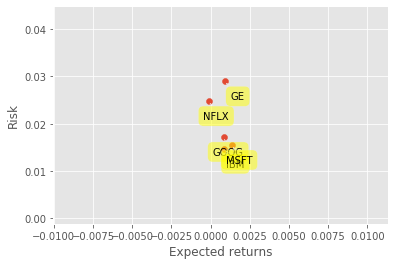

In [11]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [12]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
print(dfreg)

             Adj Close    Volume    HL_PCT  PCT_change
Date                                                  
2018-11-01  317.380005  15121500  6.862436    4.199090
2018-11-02  309.100006  13404600  4.383700   -2.798740
2018-11-05  315.440002  10283000  4.371674    1.395049
2018-11-06  310.839996   9710400  4.799901   -1.245398
2018-11-07  327.500000  13328300  5.361831    4.666030
2018-11-08  317.920013  11023900  4.856568   -3.073167
2018-11-09  303.470001  13480800  4.932943   -2.443182
2018-11-12  294.070007  10924800  4.033048   -1.976664
2018-11-13  294.399994  12232200  4.908282   -0.203392
2018-11-14  286.730011  16853600  8.209817   -4.550594
2018-11-15  290.059998   9967100  3.564778    1.593635
2018-11-16  286.209991   9099500  3.745502   -0.323892
2018-11-19  270.600006  12993800  5.890614   -4.647804
2018-11-20  266.980011  16693800  9.865906    4.850177
2018-11-21  262.130005  11023000  5.276003   -4.478539
2018-11-23  258.820007   5245100  3.345956   -0.495936
2018-11-26

In [13]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.05 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [15]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [16]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
('The linear regression confidence is ', 0.96399641826551985)
('The quadratic regression 2 confidence is ', 0.96492624557970319)
('The quadratic regression 3 confidence is ', 0.9652082834532858)
('The knn regression confidence is ', 0.92844658034790639)

('The knn regression confidence is ', 0.9284465803479064)

In [17]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

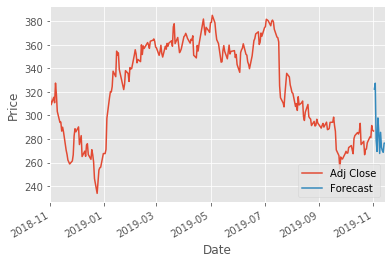

In [18]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [22]:
Forecast = pd.DataFrame(forecast_set)

Forecast.head()


TypeError: Index(...) must be called with a collection of some kind, False was passed